Dataset used : RetailRocket dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

events = pd.read_csv("D:\\Documents2\\Downloads\\archive (1)\\events.csv") 
events= events.iloc[0:50000]
item_properties = pd.read_csv("D:\\Documents2\\Downloads\\archive (1)\\item_properties_part1.csv") 
item_properties = item_properties.iloc[50000]

In [ ]:
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
events = events.sort_values(by=['visitorid', 'timestamp'])

#Feature engineering

-> Group the entire dataset by visitorid — treating each user as a session.

-> session_start: when their first event occurred.

-> session_end: when their last event occurred.

-> unique_items: how many different products this user interacted with.

-> reset_index() flattens the DataFrame so visitorid is a column, not an index.

In [ ]:
session_features = (
    events.groupby('visitorid')
    .agg(
        session_start=('timestamp', 'min'),
        session_end=('timestamp', 'max'),
        num_events=('event', 'count'),
        num_views=('event', lambda x: (x == 'view').sum()),
        num_adds=('event', lambda x: (x == 'addtocart').sum()),
        num_purchases=('event', lambda x: (x == 'transaction').sum()),
        unique_items=('itemid', pd.Series.nunique),
    )
    .reset_index()
)

session_features['session_duration'] = (session_features['session_end'] - session_features['session_start']).dt.total_seconds()
session_features = session_features.fillna(0)

In [ ]:
session_features['purchase_intent'] = (session_features['num_purchases'] > 0).astype(int)

feature_cols = ['num_events', 'num_views', 'num_adds', 'unique_items', 'session_duration']
X = session_features[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Runs the KMeans algorithm on the scaled features.

 -> Assigns each session to one of the 4 clusters.

 -> Stores the cluster number (0, 1, 2, or 3) in a new column called 'persona_cluster'.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
session_features['persona_cluster'] = kmeans.fit_predict(X_scaled)

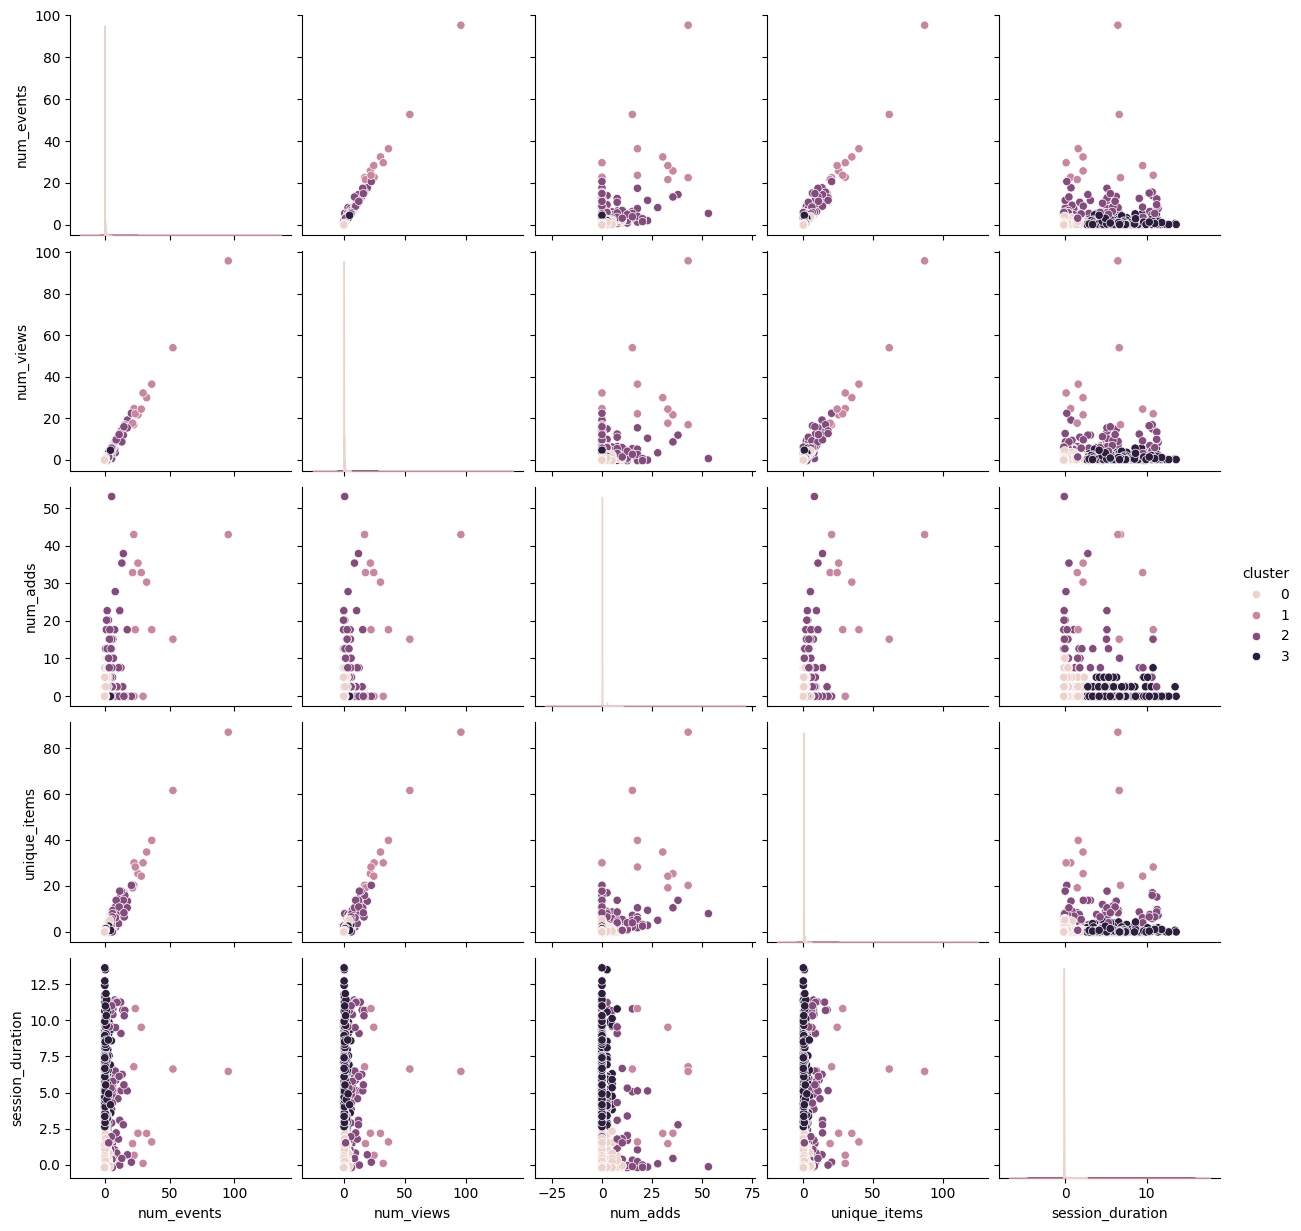

In [ ]:
sns.pairplot(pd.DataFrame(X_scaled, columns=feature_cols).assign(cluster=session_features['persona_cluster']), hue='cluster')
plt.show()

Sets up a Random Forest model:

 -> Uses 100 decision trees (n_estimators=100)

 -> Each tree learns different patterns from the data

 -> Combines their outputs to make strong, robust predictions

In [ ]:
from sklearn.model_selection import train_test_split

y = session_features['purchase_intent']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



In [8]:
print("Purchase Intent Classification Report:")
print(classification_report(y_test, y_pred))

Purchase Intent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5721
           1       0.82      0.73      0.77        51

    accuracy                           1.00      5772
   macro avg       0.91      0.86      0.88      5772
weighted avg       1.00      1.00      1.00      5772

